In [33]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle
from sklearn.cluster import KMeans

In [34]:
import ternary


In [35]:
os.environ["CUDA_VISIBLE_DEVICES"] = '012'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_gpus[0], True)

In [118]:
# Setting up training and testing data:
mean_1 = [0, 0, 0, 0, 0]
cov_1 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]

mean_2 = [10000, 10000, 10000, 10000, 10000]
cov_2 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]

mean_3 = [-10000, -10000, -10000, -10000, -10000]
cov_3 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]


x_1 = np.random.multivariate_normal(mean_1, cov_1, size=1000000)
y_1 = np.random.multivariate_normal(mean_1, cov_1, size=100000)

x_2 = np.random.multivariate_normal(mean_2, cov_2, size=1000000)
y_2 = np.random.multivariate_normal(mean_2, cov_2, size=100000)

x_3 = np.random.multivariate_normal(mean_3, cov_3, size=1000000)
y_3 = np.random.multivariate_normal(mean_3, cov_3, size=100000)


In [119]:
#Generate k-Means data for training
x_kmeans_1 =  np.random.multivariate_normal(mean_1, cov_1, size=1000)
x_kmeans_2 =  np.random.multivariate_normal(mean_2, cov_2, size=1000)
x_kmeans_3 =  np.random.multivariate_normal(mean_3, cov_3, size=1000)
rng = np.random.default_rng()
x_train_kmeans = np.concatenate((x_kmeans_1, x_kmeans_2, x_kmeans_3))
indices_kmeans = rng.permutation(np.shape(x_train_kmeans)[0])
x_train_kmeans = x_train_kmeans[indices_kmeans]

In [120]:
print(x_1[0])

[ 0.05331179  1.52429655 -0.53883696  0.4287107  -2.13550516]


Distribution of the raw samples

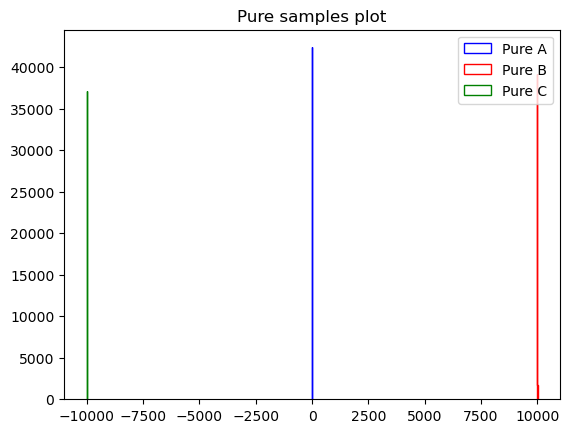

In [121]:
plt.hist(x_1[:,0], bins = 100, edgecolor = 'b', histtype = 'step', label = 'Pure A')
plt.hist(x_2[:,0], bins = 100, edgecolor = 'r', histtype = 'step', label = 'Pure B')
plt.hist(x_3[:,0], bins = 100, edgecolor = 'g', histtype = 'step', label = 'Pure C')
plt.title("Pure samples plot")
plt.legend()
plt.show()

In [122]:
# Preparing three samples
n_samples = 3
n_1_1 = 80000 #Number of signal samples in dominant class
n_1_2 = 10000
n_1_3 = 10000

n_2_1 = 70000
n_2_2 = 20000
n_2_3 = 10000

n_3_1 = 60000
n_3_2 = 25000
n_3_3 = 15000

sample_1_1_train = x_1[0:n_1_1]
#Using one-hot encoding here
true_label_sample_1_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_1_1_train)[0]).reshape(np.shape(sample_1_1_train)[0],n_samples)

sample_1_2_train = x_2[0:n_1_2]
true_label_sample_1_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_1_2_train)[0]).reshape(np.shape(sample_1_2_train)[0],n_samples)
sample_1_3_train = x_3[0:n_1_3]
true_label_sample_1_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_1_3_train)[0]).reshape(np.shape(sample_1_3_train)[0],n_samples)

sample_2_1_train = x_1[n_1_1:n_1_1+n_2_1]
#Using one-hot encoding here
true_label_sample_2_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_2_1_train)[0]).reshape(np.shape(sample_2_1_train)[0],n_samples)

sample_2_2_train = x_2[n_1_2:n_1_2 + n_2_2]
true_label_sample_2_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_2_2_train)[0]).reshape(np.shape(sample_2_2_train)[0],n_samples)
sample_2_3_train = x_3[n_1_3:n_1_3+n_2_3]
true_label_sample_2_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_2_3_train)[0]).reshape(np.shape(sample_2_3_train)[0],n_samples)

sample_3_1_train = x_1[n_1_1+n_2_1:n_1_1+n_2_1+n_3_1]
#Using one-hot encoding here
true_label_sample_3_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_3_1_train)[0]).reshape(np.shape(sample_3_1_train)[0],n_samples)

sample_3_2_train = x_2[n_1_2+n_2_2:n_1_2+n_2_2+n_3_2]
true_label_sample_3_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_3_2_train)[0]).reshape(np.shape(sample_3_2_train)[0],n_samples)
sample_3_3_train = x_3[n_1_3+n_2_3:n_1_3+n_2_3+n_3_3]
true_label_sample_3_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_3_3_train)[0]).reshape(np.shape(sample_3_3_train)[0],n_samples)






In [123]:
x_test = np.concatenate((y_1, y_2, y_3))
y_test_1 = np.tile(np.array([1., 0., 0.]), 
            np.shape(y_1)[0]).reshape(np.shape(y_1)[0],n_samples)
y_test_2 = np.tile(np.array([0., 1., 0.]), 
            np.shape(y_2)[0]).reshape(np.shape(y_2)[0],n_samples)
y_test_3 = np.tile(np.array([0., 0., 1.]), 
            np.shape(y_3)[0]).reshape(np.shape(y_3)[0],n_samples)
y_test = np.concatenate((y_test_1, y_test_2, y_test_3))
indices_test = rng.permutation(np.shape(x_test)[0])
x_test = x_test[indices_test]
y_test = y_test[indices_test]

In [91]:
#y_test = np.argmax(y_test, axis = 1)

In [124]:
print(y_test)

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


One versus all

In [125]:
rng = np.random.default_rng()
x_train_1 = np.concatenate((sample_1_1_train, sample_1_2_train, sample_1_3_train))
y_train_1 = np.tile(np.array([1., 0., 0.]), 
            np.shape(x_train_1)[0]).reshape(np.shape(x_train_1)[0],n_samples)
true_label_1 = np.concatenate((true_label_sample_1_1_train, true_label_sample_1_2_train, 
                               true_label_sample_1_3_train))
indices_1 = rng.permutation(np.shape(x_train_1)[0])

x_shuffle_1 = x_train_1[indices_1]
y_shuffle_1 = y_train_1[indices_1]
true_label_shuffle_1 = true_label_1[indices_1]

x_train_2 = np.concatenate((sample_2_1_train, sample_2_2_train, sample_2_3_train))
y_train_2 = np.tile(np.array([0., 1., 0.]), 
            np.shape(x_train_2)[0]).reshape(np.shape(x_train_2)[0],n_samples)
true_label_2 = np.concatenate((true_label_sample_2_1_train, true_label_sample_2_2_train, 
                               true_label_sample_2_3_train))
indices_2 = rng.permutation(np.shape(x_train_2)[0])

x_shuffle_2 = x_train_2[indices_2]
y_shuffle_2 = y_train_2[indices_2]
true_label_shuffle_2 = true_label_2[indices_2]

x_train_3 = np.concatenate((sample_3_1_train, sample_3_2_train, sample_3_3_train))
y_train_3 = np.tile(np.array([0., 0., 1.]), 
            np.shape(x_train_3)[0]).reshape(np.shape(x_train_3)[0],n_samples)
true_label_3 = np.concatenate((true_label_sample_3_1_train, true_label_sample_3_2_train, 
                               true_label_sample_3_3_train))
indices_3 = rng.permutation(np.shape(x_train_3)[0])

x_shuffle_3 = x_train_3[indices_3]
y_shuffle_3 = y_train_3[indices_3]
true_label_shuffle_3 = true_label_3[indices_3]


Distribution of the mixed samples

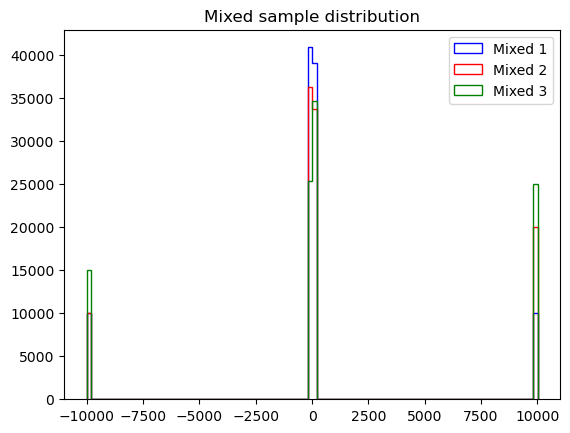

In [126]:
plt.hist(x_train_1[:,0], bins = 100, edgecolor = 'b', histtype = 'step', label = 'Mixed 1')
plt.hist(x_train_2[:,0], bins = 100, edgecolor = 'r', histtype = 'step', label = 'Mixed 2')
plt.hist(x_train_3[:,0], bins = 100, edgecolor = 'g', histtype = 'step', label = 'Mixed 3')
plt.legend()
plt.title("Mixed sample distribution")
plt.show()

Code from Feng-Yang:

In [127]:
def build_model(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(32, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [128]:
x_train = np.concatenate((x_shuffle_1, x_shuffle_2, x_shuffle_3))
y_train = np.concatenate((y_shuffle_1, y_shuffle_2, y_shuffle_3))
true_label_train = np.concatenate((true_label_shuffle_1, true_label_shuffle_2, true_label_shuffle_3))

#y_train = np.argmax(y_train, axis = 1)
#true_label_train = np.argmax(true_label_train, axis = 1)

indices_train = rng.permutation(np.shape(x_train)[0])

x_train = x_train[indices_train]
y_train = y_train[indices_train]
true_label_train = true_label_train[indices_train]


Train on 240000 samples, validate on 60000 samples
Epoch 1/50
240000/240000 [==============================] - 2s 6us/sample - loss: 85.1223 - accuracy: 0.3704 - val_loss: 26.3009 - val_accuracy: 0.3991
Epoch 2/50
240000/240000 [==============================] - 1s 4us/sample - loss: 14.7272 - accuracy: 0.3747 - val_loss: 2.9656 - val_accuracy: 0.3675
Epoch 3/50
240000/240000 [==============================] - 1s 4us/sample - loss: 4.8766 - accuracy: 0.3752 - val_loss: 3.9364 - val_accuracy: 0.3839
Epoch 4/50
240000/240000 [==============================] - 1s 4us/sample - loss: 2.3248 - accuracy: 0.3752 - val_loss: 1.7492 - val_accuracy: 0.3842
Epoch 5/50
240000/240000 [==============================] - 1s 4us/sample - loss: 1.3441 - accuracy: 0.3796 - val_loss: 1.1527 - val_accuracy: 0.3835
Epoch 6/50
240000/240000 [==============================] - 1s 4us/sample - loss: 1.2035 - accuracy: 0.3781 - val_loss: 1.0997 - val_accuracy: 0.3835
Epoch 7/50
240000/240000 [====================

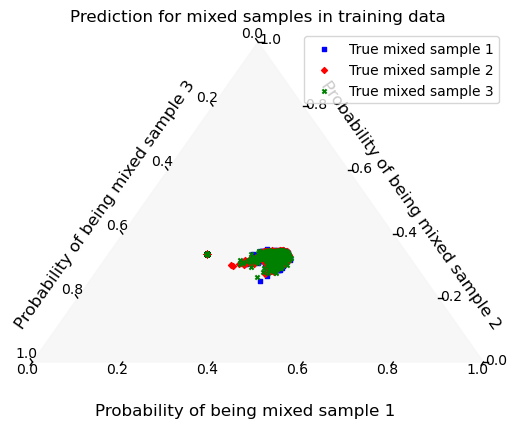

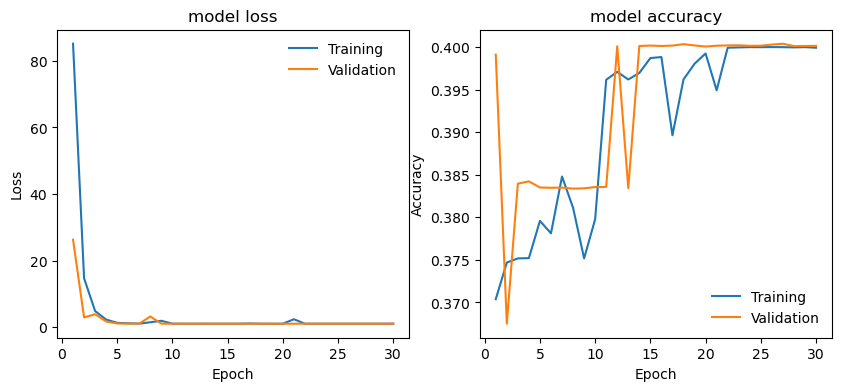

In [129]:
model = build_model(x_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10)
y_train_1 = y_train
for i in range(1):
    history = model.fit(x_train, y_train_1, validation_split = 0.2, epochs=50, batch_size=1024, verbose=1, 
                    callbacks=[
                              early_stopping,
                               ])
    predict = model.predict(x_train)

    predict_0 = predict[np.argmax(y_train_1, axis = 1) == 0]
    predict_1 = predict[np.argmax(y_train_1, axis = 1) == 1]
    predict_2 = predict[np.argmax(y_train_1, axis = 1) == 2]
    
    # Set Axis labels and Title
    scale = 1.0
    fontsize = 12
    offset = 0.1
    figure, tax = ternary.figure(scale=scale)

    tax.set_title("Prediction for mixed samples in training data", fontsize=fontsize)
    tax.left_axis_label("Probability of being mixed sample 3", fontsize=fontsize, offset=offset)
    tax.right_axis_label("Probability of being mixed sample 2", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("Probability of being mixed sample 1", fontsize=fontsize, offset=offset)
    tax.scatter(predict_0, color = 'blue', marker = 's', s = 9, label="True mixed sample 1")
    tax.scatter(predict_1, color = 'red', marker = 'D', s = 9, label="True mixed sample 2")
    tax.scatter(predict_2, color = 'green', marker = 'x', s = 9, label="True mixed sample 3")

    # Set ticks
    tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f")

    # Background color
    tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.legend()
    ternary.plt.show()
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    x = range(1, len(history.history['loss']) + 1)

    ax[0].plot(x, history.history['loss'], label='Training')
    ax[0].plot(x, history.history['val_loss'], label='Validation')

    ax[0].legend(frameon=False)
    ax[0].set_title(f'model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(x, history.history['accuracy'], label='Training')
    ax[1].plot(x, history.history['val_accuracy'], label='Validation')

    ax[1].legend(frameon=False)
    ax[1].set_title(f'model accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    plt.show()
    predict[np.argmax(predict, axis = 1) == 0] = [1., 0., 0.]
    predict[np.argmax(predict, axis = 1) == 1] = [0., 1., 0.]
    predict[np.argmax(predict, axis = 1) == 2] = [0., 0., 1.]
    y_train_1 = predict
    

In [130]:
x_train_post_model = model.predict(x_train_kmeans)


In [54]:
#Preparing data to train for the KMeans classification
#kmeans = KMeans(n_clusters=3, init = np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]]))

In [20]:
#kmeans.fit(x_train_post_model)


/usr/local/anaconda2/envs/ML/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


KMeans(init=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]),
       n_clusters=3)

In [131]:
from sklearn.cluster import SpectralClustering

In [ ]:
# Perform Spectral Clustering
spec_model = SpectralClustering(n_clusters=3, assign_labels = 'discretize')
spec_model.fit(x_train_post_model)

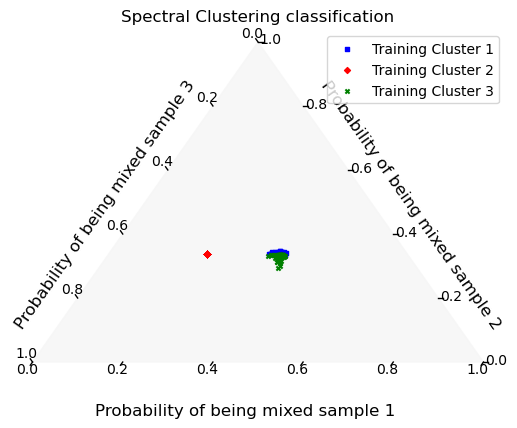

In [133]:
scale = 1.0
fontsize = 12
offset = 0.1
figure, tax = ternary.figure(scale=scale)
predict_kmeans = spec_model.fit_predict(x_train_post_model)
predict_kmeans_0 = x_train_post_model[predict_kmeans == 0]
predict_kmeans_1 = x_train_post_model[predict_kmeans == 1]
predict_kmeans_2 = x_train_post_model[predict_kmeans == 2]
#centroids = spec_model.cluster_centers_
tax.set_title("Spectral Clustering classification", fontsize=fontsize)
tax.left_axis_label("Probability of being mixed sample 3", fontsize=fontsize, offset=offset)
tax.right_axis_label("Probability of being mixed sample 2", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Probability of being mixed sample 1", fontsize=fontsize, offset=offset)
tax.scatter(predict_kmeans_0, color = 'blue', marker = 's', s = 9, label="Training Cluster 1")
tax.scatter(predict_kmeans_1, color = 'red', marker = 'D', s = 9, label="Training Cluster 2")
tax.scatter(predict_kmeans_2, color = 'green', marker = 'x', s = 9, label="Training Cluster 3")
# Set ticks
tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f")

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.legend()
ternary.plt.show()

Spectral Clustering accuracy on pure data, 65.30%


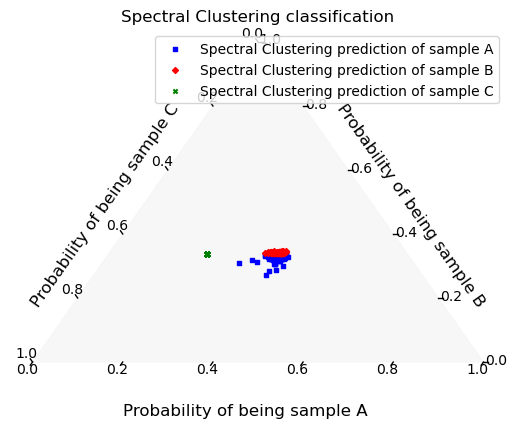

In [134]:
# Testing KMeans prediction:
x_predict_pre_kmeans = model.predict(x_test[0:10000])
x_predict_post_kmeans = spec_model.fit_predict(x_predict_pre_kmeans)
predicted_labels = np.argmax(y_test[0:10000], axis = 1)
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
#Rematching of labels
conf_matrix = confusion_matrix(x_predict_post_kmeans, predicted_labels)
# Step 2: Use Hungarian algorithm for optimal label assignment
row_ind, col_ind = linear_sum_assignment(-conf_matrix)  # Maximize matches

# Step 3: Map predicted labels to desired labels
label_mapping = {col: row for row, col in zip(row_ind, col_ind)}

# Apply mapping to reorder labels
final_labels = np.array([label_mapping[label] for label in x_predict_post_kmeans])

accuracy = np.mean(final_labels == np.argmax(y_test[0:10000], axis = 1))

print(f"Spectral Clustering accuracy on pure data, {accuracy*100:.2f}%")
scale = 1.0
fontsize = 12
offset = 0.1
figure, tax = ternary.figure(scale=scale)

predict_kmeans_0 = x_predict_pre_kmeans[final_labels == 0]
predict_kmeans_1 = x_predict_pre_kmeans[final_labels == 1]
predict_kmeans_2 = x_predict_pre_kmeans[final_labels == 2]
tax.set_title("Spectral Clustering classification", fontsize=fontsize)
tax.left_axis_label("Probability of being sample C", fontsize=fontsize, offset=offset)
tax.right_axis_label("Probability of being sample B", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Probability of being sample A", fontsize=fontsize, offset=offset)
tax.scatter(predict_kmeans_0, color = 'blue', marker = 's', s = 9, label="Spectral Clustering prediction of sample A")
tax.scatter(predict_kmeans_1, color = 'red', marker = 'D', s = 9, label="Spectral Clustering prediction of sample B")
tax.scatter(predict_kmeans_2, color = 'green', marker = 'x', s = 9, label="Spectral Clustering prediction of sample C")
# Set ticks
tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f")

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.legend(loc = 'upper right')
ternary.plt.show()

One-vs-All Accuracy on Mixed Data: 39.91%


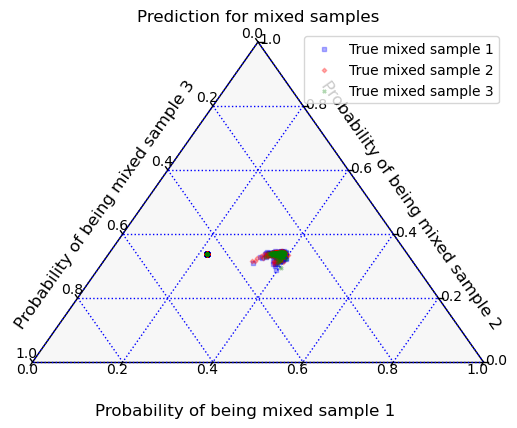

In [135]:
loss, accuracy = model.evaluate(x_train[-100000:], y_train[-100000:], verbose=0)
print(f"One-vs-All Accuracy on Mixed Data: {accuracy * 100:.2f}%")
y_predict = model.predict(x_train[-100000:])
x_predict_0 = y_predict[np.argmax(y_train[-100000:], axis = 1) == 0]
x_predict_1 = y_predict[np.argmax(y_train[-100000:], axis = 1) == 1]
x_predict_2 = y_predict[np.argmax(y_train[-100000:], axis = 1) == 2]
x_plot_0 =  (x_predict_0[rng.permutation(np.shape(x_predict_0)[0])])[0:3000]
x_plot_1 =  (x_predict_1[rng.permutation(np.shape(x_predict_1)[0])])[0:3000]
x_plot_2 =  (x_predict_2[rng.permutation(np.shape(x_predict_2)[0])])[0:3000]

## Boundary and Gridlines
scale = 1.0
figure, tax = ternary.figure(scale=scale)
fig.set_size_inches(10, 10)
# Draw Boundary and Gridlines
tax.boundary(linewidth=1)
tax.gridlines(color="blue", multiple=0.2, linewidth=1)

# Set Axis labels and Title
fontsize = 12
offset = 0.1
tax.set_title("Prediction for mixed samples", fontsize=fontsize)
tax.left_axis_label("Probability of being mixed sample 3", fontsize=fontsize, offset=offset)
tax.right_axis_label("Probability of being mixed sample 2", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Probability of being mixed sample 1", fontsize=fontsize, offset=offset)
tax.scatter(x_plot_0, color = 'blue', marker = 's', s = 5, alpha = 0.3, label="True mixed sample 1")
tax.scatter(x_plot_1, color = 'red', marker = 'D', s = 5, alpha = 0.3, label="True mixed sample 2")
tax.scatter(x_plot_2, color = 'green', marker = 'x', s = 5, alpha = 0.3, label="True mixed sample 3")

# Set ticks
tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f")

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.legend()
ternary.plt.show()


One-vs-All Test Accuracy on Pure Data: 66.65%


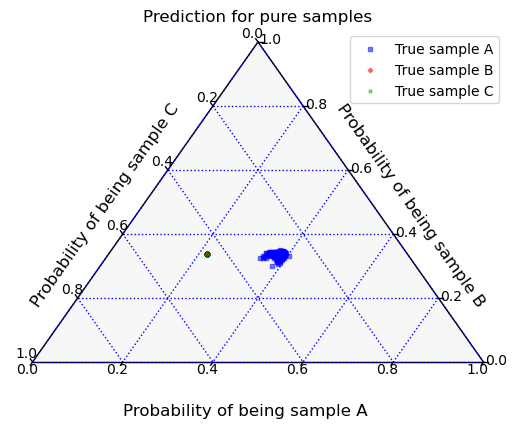

In [136]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"One-vs-All Test Accuracy on Pure Data: {accuracy * 100:.2f}%")
x_predict = model.predict(x_test)

x_predict_0 = x_predict[np.argmax(y_test, axis = 1) == 0]
x_predict_1 = x_predict[np.argmax(y_test, axis = 1) == 1]
x_predict_2 = x_predict[np.argmax(y_test, axis = 1) == 2]
x_plot_0 =  (x_predict_0[rng.permutation(np.shape(x_predict_0)[0])])[0:3000]
x_plot_1 =  (x_predict_1[rng.permutation(np.shape(x_predict_1)[0])])[0:3000]
x_plot_2 =  (x_predict_2[rng.permutation(np.shape(x_predict_2)[0])])[0:3000]

## Boundary and Gridlines
scale = 1.0
figure, tax = ternary.figure(scale=scale)
fig.set_size_inches(10, 10)
# Draw Boundary and Gridlines
tax.boundary(linewidth=1)
tax.gridlines(color="blue", multiple=0.2, linewidth=1)

# Set Axis labels and Title
fontsize = 12
offset = 0.1
tax.set_title("Prediction for pure samples", fontsize=fontsize)
tax.left_axis_label("Probability of being sample C", fontsize=fontsize, offset=offset)
tax.right_axis_label("Probability of being sample B", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Probability of being sample A", fontsize=fontsize, offset=offset)
tax.scatter(x_plot_0, color = 'blue', marker = 's', s = 5, alpha = 0.5, label="True sample A")
tax.scatter(x_plot_1, color = 'red', marker = 'D', s = 5, alpha = 0.5, label="True sample B")
tax.scatter(x_plot_2, color = 'green', marker = 'x', s = 5, alpha = 0.5, label="True sample C")


# Set ticks
tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f")

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.legend()
ternary.plt.show()


In [102]:
print(x_predict_1)

[[2.5773810e-22 8.1354193e-27 1.0000000e+00]
 [1.0000000e+00 2.0790926e-19 0.0000000e+00]
 [3.2670426e-01 6.5691285e-12 6.7329574e-01]
 ...
 [9.9968433e-01 1.0714281e-04 2.0857593e-04]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"One-vs-All Test Accuracy on Pure Data: {accuracy * 100:.2f}%")
x_predict = model.predict(x_test)

x_predict_0 = x_predict[np.argmax(y_test, axis = 1) == 0]
x_predict_1 = x_predict[np.argmax(y_test, axis = 1) == 1]
x_predict_2 = x_predict[np.argmax(y_test, axis = 1) == 2]
x_plot_0 =  (x_predict_0[rng.permutation(np.shape(x_predict_0)[0])])[0:3000]
x_plot_1 =  (x_predict_1[rng.permutation(np.shape(x_predict_1)[0])])[0:3000]
x_plot_2 =  (x_predict_2[rng.permutation(np.shape(x_predict_2)[0])])[0:3000]

## Boundary and Gridlines
scale = 1.0
figure, tax = ternary.figure(scale=scale)
fig.set_size_inches(10, 10)
# Draw Boundary and Gridlines
tax.boundary(linewidth=1)
tax.gridlines(color="blue", multiple=0.2, linewidth=1)

# Set Axis labels and Title
fontsize = 12
offset = 0.1
tax.set_title("Prediction for pure samples", fontsize=fontsize)
tax.left_axis_label("Probability of being sample C", fontsize=fontsize, offset=offset)
tax.right_axis_label("Probability of being sample B", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Probability of being sample A", fontsize=fontsize, offset=offset)

tax.scatter(x_plot_1, color = 'red', marker = 'D', s = 5, alpha = 0.5, label="True sample B")
tax.scatter(x_plot_2, color = 'green', marker = 'x', s = 5, alpha = 0.5, label="True sample C")
tax.scatter(x_plot_0, color = 'blue', marker = 's', s = 5, alpha = 0.5, label="True sample A")

# Set ticks
tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f")

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.legend()
ternary.plt.show()


In [ ]:
'''
plt.scatter(x_plot_0[:,0], x_plot_0[:,1], c = 'b', s = 1,label = "Pure Sample A")
plt.scatter(x_plot_1[:,0], x_plot_1[:,1], c = 'r', s = 1,label = "Pure Sample B")
plt.scatter(x_plot_2[:,0], x_plot_2[:,1], c = 'g', s = 1,label = "Pure Sample C")
plt.xlabel('Probability of being sample A')
plt.ylabel('Probability of being sample B')
plt.legend()
plt.title("Prediction for pure samples")
plt.show()
'''

In [87]:
print(np.shape(np.argmax(x_predict_0, axis = 1)[np.argmax(x_predict_0, axis = 1) == 0]))
print(np.shape(np.argmax(x_predict_1, axis = 1)[np.argmax(x_predict_1, axis = 1) == 1]))
print(np.shape(np.argmax(x_predict_2, axis = 1)[np.argmax(x_predict_2, axis = 1) == 2]))


(78664,)
(10061,)
(75390,)


In [37]:
loss, accuracy = model.evaluate(y_3, y_test_3, verbose=0)
print(f"One-vs-All Test Accuracy: {accuracy * 100:.2f}%")

One-vs-All Test Accuracy: 87.23%


In [89]:
print(np.argmax(x_predict_0, axis = 1) == 1)

[False False False ... False  True False]


In [90]:
print(np.mean(x_predict_0), np.mean(x_predict_1), np.mean(x_predict_2))

0.33333337 0.3333333 0.33333337


One versus Rest strategy

In [91]:
def build_model_ovr(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(32, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

Train on 240000 samples, validate on 60000 samples
Epoch 1/50
240000/240000 [==============================] - 2s 7us/sample - loss: 0.6317 - accuracy: 0.6652 - val_loss: 0.6304 - val_accuracy: 0.6666
Epoch 2/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6296 - accuracy: 0.6667 - val_loss: 0.6299 - val_accuracy: 0.6666
Epoch 3/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6295 - accuracy: 0.6667 - val_loss: 0.6298 - val_accuracy: 0.6666
Epoch 4/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6294 - accuracy: 0.6667 - val_loss: 0.6297 - val_accuracy: 0.6666
Epoch 5/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6294 - accuracy: 0.6667 - val_loss: 0.6296 - val_accuracy: 0.6666
Epoch 6/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6293 - accuracy: 0.6667 - val_loss: 0.6299 - val_accuracy: 0.6666
Epoch 7/50
240000/240000 [=======================

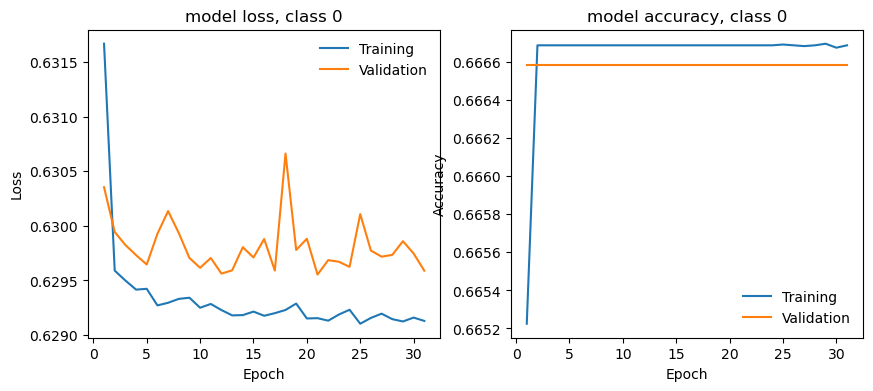

Train on 240000 samples, validate on 60000 samples
Epoch 1/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6384 - accuracy: 0.6655 - val_loss: 0.6356 - val_accuracy: 0.6682
Epoch 2/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6366 - accuracy: 0.6663 - val_loss: 0.6351 - val_accuracy: 0.6682
Epoch 3/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6365 - accuracy: 0.6663 - val_loss: 0.6350 - val_accuracy: 0.6682
Epoch 4/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6364 - accuracy: 0.6663 - val_loss: 0.6351 - val_accuracy: 0.6682
Epoch 5/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6363 - accuracy: 0.6663 - val_loss: 0.6351 - val_accuracy: 0.6682
Epoch 6/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6363 - accuracy: 0.6663 - val_loss: 0.6351 - val_accuracy: 0.6682
Epoch 7/50
240000/240000 [=======================

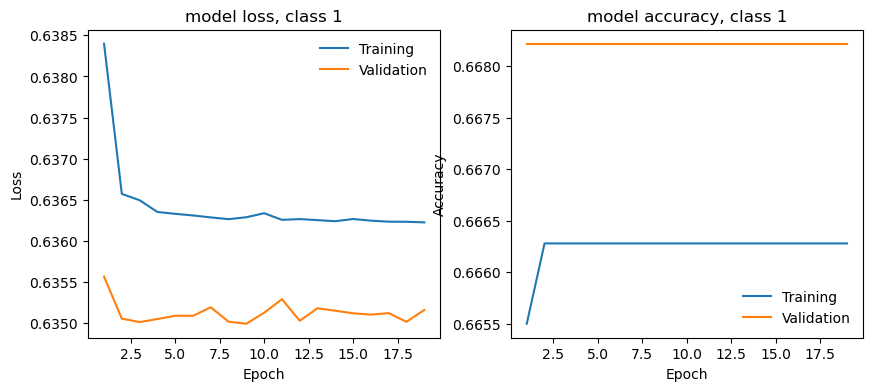

Train on 240000 samples, validate on 60000 samples
Epoch 1/50
240000/240000 [==============================] - 1s 6us/sample - loss: 0.6340 - accuracy: 0.6655 - val_loss: 0.6340 - val_accuracy: 0.6652
Epoch 2/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6313 - accuracy: 0.6670 - val_loss: 0.6327 - val_accuracy: 0.6653
Epoch 3/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6311 - accuracy: 0.6669 - val_loss: 0.6321 - val_accuracy: 0.6652
Epoch 4/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6310 - accuracy: 0.6670 - val_loss: 0.6319 - val_accuracy: 0.6653
Epoch 5/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6310 - accuracy: 0.6669 - val_loss: 0.6320 - val_accuracy: 0.6652
Epoch 6/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6310 - accuracy: 0.6669 - val_loss: 0.6321 - val_accuracy: 0.6652
Epoch 7/50
240000/240000 [=======================

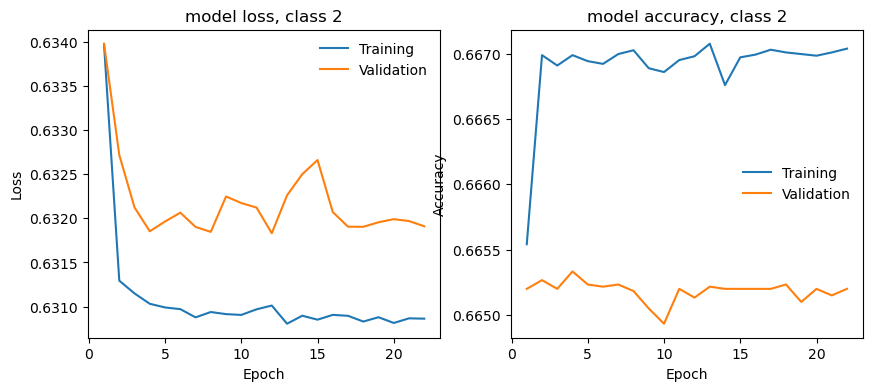

In [92]:
models = []
for class_index in range(n_samples):
    y_train_bin = np.where(np.argmax(y_train, axis = 1) == class_index, 1, 0)
    model_2 = build_model_ovr(x_train.shape[1])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10)
    history_2 = model_2.fit(x_train, y_train_bin, validation_split = 0.2, epochs=50, batch_size=1024, verbose=1, 
                    callbacks=[
                              early_stopping,
                               ])
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    x = range(1, len(history_2.history['loss']) + 1)

    ax[0].plot(x, history_2.history['loss'], label='Training')
    ax[0].plot(x, history_2.history['val_loss'], label='Validation')

    ax[0].legend(frameon=False)
    ax[0].set_title(f'model loss, class {class_index}')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(x, history_2.history['accuracy'], label='Training')
    ax[1].plot(x, history_2.history['val_accuracy'], label='Validation')

    ax[1].legend(frameon=False)
    ax[1].set_title(f'model accuracy, class {class_index}')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    plt.show()
    
    models.append(model_2)

In [93]:
# Making predictions using the OvR strategy
def predict_ovr(models, X_test):
    predictions = np.zeros((X_test.shape[0], len(models)))
    
    # Predict using each model
    for idx, model in enumerate(models):
        pred = model.predict(X_test)
        predictions[:, idx] = pred.flatten()
    
    # The final class is the one with the highest confidence score
    return np.argmax(predictions, axis=1), predictions

# Get final predictions
final_predictions, predictions = predict_ovr(models, x_test)

# Calculate accuracy
accuracy = np.mean(final_predictions == np.argmax(y_test, axis = 1))
print(f"One-vs-Rest Test Accuracy: {accuracy * 100:.2f}%")
print(final_predictions)

One-vs-Rest Test Accuracy: 53.14%
[0 0 0 ... 2 2 2]


In [94]:
loss_1, accuracy_1 = models[0].evaluate(y_1, np.zeros_like(y_test_1[:,0]), verbose=0)
loss_2, accuracy_2 = models[1].evaluate(y_2, np.zeros_like(y_test_2[:,0]), verbose=0)
loss_3, accuracy_3 = models[2].evaluate(y_3, np.zeros_like(y_test_3[:,0]), verbose=0)

print(f"One-vs-All Test Accuracy for Model 0 for pure samples A testing data: {accuracy_1 * 100:.2f}%")
print(f"One-vs-All Test Accuracy for Model 1 for pure samples B testing data: {accuracy_2 * 100:.2f}%")
print(f"One-vs-All Test Accuracy for Model 2 for pure samples C testing data: {accuracy_3 * 100:.2f}%")

One-vs-All Test Accuracy for Model 0 for pure samples A testing data: 100.00%
One-vs-All Test Accuracy for Model 1 for pure samples B testing data: 100.00%
One-vs-All Test Accuracy for Model 2 for pure samples C testing data: 100.00%


In [95]:
print(models[2].predict(x_test).max())

0.5075428


In [96]:
predictions = predictions / predictions.sum(axis=1, keepdims=True)


In [ ]:
print(f"One-vs-Rest Test Accuracy: {accuracy * 100:.2f}%")

y_predict_0 = predictions[np.argmax(y_test, axis = 1) == 0]
y_predict_1 = predictions[np.argmax(y_test, axis = 1) == 1]
y_predict_2 = predictions[np.argmax(y_test, axis = 1) == 2]
y_plot_0 =  (y_predict_0[rng.permutation(np.shape(x_predict_0)[0])])[0:3000]
y_plot_1 =  (y_predict_1[rng.permutation(np.shape(x_predict_1)[0])])[0:3000]
y_plot_2 =  (y_predict_2[rng.permutation(np.shape(x_predict_2)[0])])[0:3000]
## Boundary and Gridlines
scale = 1.0
figure, tax = ternary.figure(scale=scale)
fig.set_size_inches(10, 10)
# Draw Boundary and Gridlines
tax.boundary(linewidth=1)
tax.gridlines(color="blue", multiple=0.2, linewidth=1)

# Set Axis labels and Title
fontsize = 12
offset = 0.1
tax.set_title("Prediction for pure samples", fontsize=fontsize)
tax.left_axis_label("Probability of being sample C", fontsize=fontsize, offset=offset)
tax.right_axis_label("Probability of being sample B", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Probability of being sample A", fontsize=fontsize, offset=offset)
tax.scatter(y_plot_0, color = 'blue', marker = 's', s = 5, alpha = 0.5, label="True sample A")
tax.scatter(y_plot_1, color = 'red', marker = 'D', s = 5, alpha = 0.5, label="True sample B")
tax.scatter(y_plot_2, color = 'green', marker = 'x', s = 5, alpha = 0.5, label="True sample C")




# Set ticks
tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f")

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.legend()
ternary.plt.show()
